# Solving advection equation using ODE-ELM and ODE-SWIM for advection coefficient of 40

In [5]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BoundaryCompliantAnsatz
from swimpde import AdvectionSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
np.random.seed(2)
import time
cmap = cm.jet
import matplotlib.ticker as ticker


### Problem setup

In [6]:
# create equally spaced points in a square
n_points_1d = 400 
x_lim = [0, 2 * np.pi]

# coordinates of boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

# initial condition
def u0(x):
    return np.sin(x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# boundary condition
boundary_condition = "periodic" #strict

# Analytical solution
def analytical_sol(x, t, beta):
    return np.sin(x - beta * t)

# Test data
t_eval = np.linspace(0, 1, 100) # time domain
x_space_test = np.linspace(x_lim[0], x_lim[-1], 256).reshape((-1, 1)) # space domain
xx_test, yy_test = np.meshgrid(x_space_test, t_eval)
X_test = np.hstack((xx_test.reshape(-1, 1), yy_test.reshape(-1, 1))) # Uniform test points


### Fit and evaluate SWIM-ODE and ELM-ODE for good hyper-parameters 

In [7]:
conv_coeff = [40] # Values of convection coefficient
n_c = 400 # Number of data points for convection coefficient 100
seeds = [1, 2, 3]
experiments = []

n_IBF = 380
n_OBF = 14

# Parameter sampler for ELM: Sample weights from a normal distribution and biases uniformly from [-4, 4]
def sample_parameters_randomly(x, _, rng):
    weights = rng.normal(loc=0, scale=1, size=(x.shape[1], n_IBF))
    biases = rng.uniform(low=-4, high=4, size=(1, n_IBF)) # low=-np.pi, high=np.pi,  2 * np.pi
    idx0 = None
    idx1 = None
    return weights, biases, idx0, idx1

# Periodic basis functions
def periodic_outer_basis_sine(x_space, n_outer_basis=None, initial_condition=None):
    return np.column_stack([
        sine_cos(x_space * (i+1))
        for i in range(n_outer_basis//2)
        for sine_cos in [np.sin, np.cos]
    ])

# Ground truth for the selected convection coefficient
u_true_test = analytical_sol(x_space_test, t_eval, conv_coeff).T

# Loop over different seeds
rmse_swim = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))
rel_err_swim = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
j = 0
info = []
for seed in seeds:
    ansatz_swim = BoundaryCompliantAnsatz(
            n_outer_basis=n_OBF,
            n_inner_basis=n_IBF,
            activation="tanh",
            random_state=seed,
            regularization_scale=1e-10,
            target_gen=periodic_outer_basis_sine,
        )
    ansatz_elm = BoundaryCompliantAnsatz(
            n_outer_basis=n_OBF,
            n_inner_basis=n_IBF,
            activation="tanh",
            random_state=seed,
            regularization_scale=1e-10,
            target_gen=periodic_outer_basis_sine,
            parameter_sampler = sample_parameters_randomly
    )
    
    # Collocation points in space
    x_space = np.linspace(x_lim[0], x_lim[1], n_c).reshape((-1, 1))

    # interior points
    x_space_inner = x_space[1:-1]
    interior_points = x_space_inner

    # Domain
    domain = Domain(
        interior_points=interior_points,
        boundary_points=boundary_points,
    )
    
    adv_solver_swim = AdvectionSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        u0=u0,
        boundary_condition=boundary_condition,
        c=conv_coeff,
        forcing=forcing,
        regularization_scale=1e-10,
    )
    adv_solver_elm = AdvectionSolver(
        domain=domain, 
        ansatz=ansatz_elm,
        u0=u0,
        boundary_condition=boundary_condition,
        c=conv_coeff,
        forcing=forcing,
        regularization_scale=1e-10,
    )
    
    # Compute weights and biases of the SWIM network
    time_blocks = 1
    t_swim_start = time.time()
    sol_swim, solver_status_swim = adv_solver_swim.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=1e-12);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start
    
    t_elm_start = time.time()
    sol_elm, solver_status_elm = adv_solver_elm.fit(t_span=[0, np.max(t_eval)], rtol = 1e-10, atol = 1e-10, svd_cutoff=1e-12);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start
    
    # Evaluate on test data
    u_elm_test = adv_solver_elm.evaluate(x_eval=x_space_test, t_eval = t_eval, solver_status=solver_status_elm).T
    u_swim_test = adv_solver_swim.evaluate(x_eval=x_space_test, t_eval = t_eval, solver_status=solver_status_swim).T #, solver_status=solver_status
                
    # Compute metrics
    rmse_elm[j] = np.sqrt(mean_squared_error(u_true_test, u_elm_test))
    rmse_swim[j] = np.sqrt(mean_squared_error(u_true_test, u_swim_test))  # mean squared error
    rel_err_elm[j] = rmse_elm[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
    rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true_test, np.zeros_like(u_true_test)))
    j += 1

    info.append(np.mean(time_elm))
    info.append(np.mean(time_swim))
    info.append(np.mean(rmse_elm))
    info.append(np.std(rmse_elm))
    info.append(np.mean(rmse_swim))
    info.append(np.std(rmse_swim))
    info.append(np.mean(rel_err_elm))
    info.append(np.std(rel_err_elm))
    info.append(np.mean(rel_err_swim))
    info.append(np.std(rel_err_swim))

    print(info)
        

[0.7152887980143229, 0.7208210627237955, 0.6666666683532934, 0.4714045184057814, 0.6666666811783809, 0.4714045002683687, 0.6666666690518834, 0.47140451741782563, 0.666666687189042, 0.47140449176801014]
[0.7152887980143229, 0.7208210627237955, 0.6666666683532934, 0.4714045184057814, 0.6666666811783809, 0.4714045002683687, 0.6666666690518834, 0.47140451741782563, 0.666666687189042, 0.47140449176801014, 0.43882322311401367, 0.4320869445800781, 0.333333340886142, 0.4714045154503895, 0.33333335020188376, 0.47140450886316554, 0.3333333440144681, 0.4714045132383289, 0.3333333571887318, 0.47140450392271815]
[0.7152887980143229, 0.7208210627237955, 0.6666666683532934, 0.4714045184057814, 0.6666666811783809, 0.4714045002683687, 0.6666666690518834, 0.47140451741782563, 0.666666687189042, 0.47140449176801014, 0.43882322311401367, 0.4320869445800781, 0.333333340886142, 0.4714045154503895, 0.33333335020188376, 0.47140450886316554, 0.3333333440144681, 0.4714045132383289, 0.3333333571887318, 0.4714045

### Comparison of solutions using SWIM-ODE and ELM-ODE to true solution

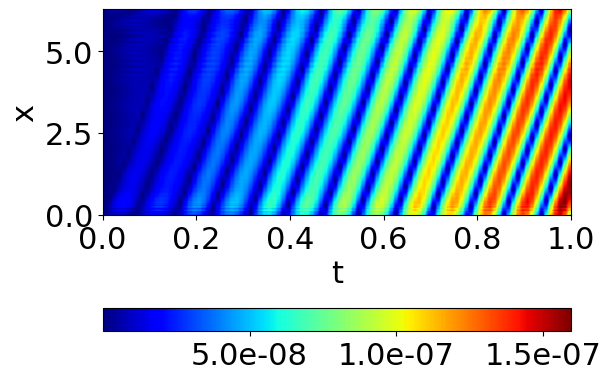

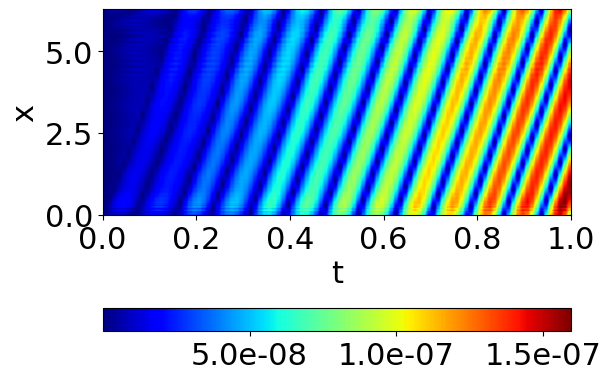

In [10]:
fontsize = 22
aspect = 0.07

# visualize the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)#
extent = [np.min(t_eval) , np.max(t_eval), np.min(x_space), np.max(x_space)]
sol_img1 = ax.imshow(abs(u_swim_test-u_true_test).T, extent=extent, origin='lower', aspect=aspect, cmap=cmap)#, vmin=vlim[0], vmax=vlim[1]
cb = fig.colorbar(sol_img1, ax=ax, location='bottom',aspect=20)#, fraction=0.046 * 3 

# Set the formatter for the colorbar to scientific notation
cb.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.1e}')
cb.update_ticks()

# Set the font size of the colorbar labels
cb.ax.tick_params(labelsize=fontsize)  # Change 12 to your desired font size
ax.set_xlabel('t', fontsize=fontsize)
ax.set_ylabel('x', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('adv_error_swim.pdf')

# visualize the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)#
extent = [np.min(t_eval) , np.max(t_eval), np.min(x_space), np.max(x_space)]
sol_img1 = ax.imshow(abs(u_swim_test-u_true_test).T, extent=extent, origin='lower', aspect=aspect, cmap=cmap)#, vmin=vlim[0], vmax=vlim[1]
cb = fig.colorbar(sol_img1, ax=ax, location='bottom',aspect=20)#, fraction=0.046 * 3 

# Set the formatter for the colorbar to scientific notation
cb.formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.1e}')
cb.update_ticks()

# Set the font size of the colorbar labels
cb.ax.tick_params(labelsize=fontsize)  # Change 12 to your desired font size
ax.set_xlabel('t', fontsize=fontsize)
ax.set_ylabel('x', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('adv_error_elm.pdf')
